# Some regularizations and optimization algorithms on [Abalone](http://archive.ics.uci.edu/ml/datasets/Abalone) dataset
By [Zahra Taheri](https://github.com/zahta), November 25, 2020

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

# Set the seeds to ensure reproducibility
np.random.seed(1)
torch.manual_seed(1)

## Reading the dataset

In [2]:
data=pd.read_csv('abalone.csv')
data.shape

(4177, 9)

In [3]:
data.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


## Descriptive statistics and data visualizations

In [5]:
#Describe the dataset

data.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [6]:
#Check the no. of unique items in each categorical column

data.select_dtypes('object').nunique()

Sex    3
dtype: int64

In [7]:
# Percentage of missing data in each column

number_of_columns = data.shape[0]
percentage_of_missing_data = data.isnull().sum()/number_of_columns
print(percentage_of_missing_data)

Sex               0.0
Length            0.0
Diameter          0.0
Height            0.0
Whole weight      0.0
Shucked weight    0.0
Viscera weight    0.0
Shell weight      0.0
Rings             0.0
dtype: float64


In [8]:
data['age'] = data['Rings']+1.5
data.drop('Rings', axis = 1, inplace = True)
data.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5


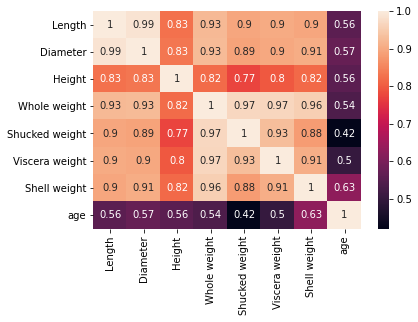

In [9]:
# Correlations

sns.heatmap(data.corr(), annot = True)

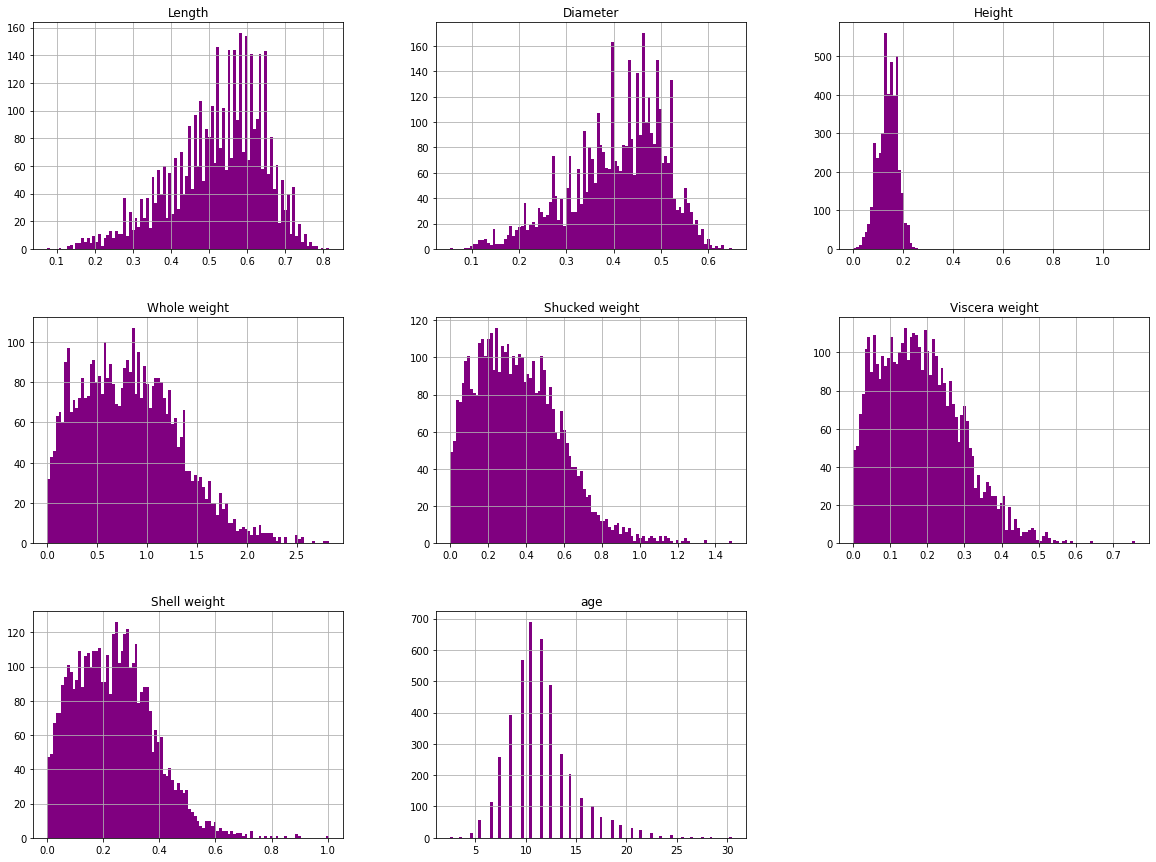

In [10]:
data.hist(bins=100, figsize=(20,15), color='purple')

plt.show()

In [11]:
#Preprocess the categorical input feature, `Sex`:
data_cat = data[["Sex"]]
data_cat.head(10)

,Sex
0,M
1,M
2,F
3,M
4,I
5,I
6,F
7,F
8,M
9,F


In [12]:
data["M"] = np.nan
data["F"] = np.nan
data["I"] = np.nan
columnName='Sex'
for i in range (len(data[columnName])):
    if data[columnName][i]=='M':
        data['M'][i]=1
        data['F'][i]=0
        data['I'][i]=0
    elif data[columnName][i]=='F':
        data['M'][i]=0
        data['F'][i]=1
        data['I'][i]=0
    elif data[columnName][i]=='I' :
        data['M'][i]=0
        data['F'][i]=0
        data['I'][i]=1
data=data.drop(['Sex'],axis=1)

In [13]:
data.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,age,M,F,I
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5,1.0,0.0,0.0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5,1.0,0.0,0.0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5,0.0,1.0,0.0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5,1.0,0.0,0.0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5,0.0,0.0,1.0


In [14]:
from sklearn import preprocessing

X=data.drop(['age'],axis=1)
y=data['age']
X = preprocessing.normalize(X)

print(X.shape)
print(y.shape)

(4177, 10)
(4177,)


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train.shape

(2923, 10)

In [16]:
train_data = X_train
test_data = X_test
train_labels = y_train.values.reshape(-1,1)
test_labels = y_test.values.reshape(-1,1)

## Preparation of the dataset for PyTorch

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [18]:
from torch.utils.data import TensorDataset, DataLoader

tensor_x = torch.tensor(train_data, dtype=torch.float).to(device) # transform to torch tensor
tensor_x2 = torch.tensor(test_data, dtype=torch.float).to(device) 

In [19]:
tensor_y = torch.tensor(train_labels, dtype=torch.float).to(device)
tensor_y2 = torch.tensor(test_labels, dtype=torch.float).to(device)

In [20]:
train_dataset = TensorDataset(tensor_x, tensor_y) # create your dataset
test_dataset = TensorDataset(tensor_x2,tensor_y2)

## Building Feedforward Neural Networks with PyTorch

In [21]:
def compute_loss(net, data_loader):
    curr_loss = 0.
    with torch.no_grad():
        for cnt, (features, targets) in enumerate(data_loader):
            features = features.to(device)
            targets = targets.to(device)
            outputs = net.forward(features)
            loss = criterion(outputs, targets)
            curr_loss += loss
        return float(curr_loss)/cnt

## Regularizations (Ensemble Methods)

- [Ensembles: the only (almost) free Lunch in Machine Learning](https://towardsdatascience.com/ensembles-the-almost-free-lunch-in-machine-learning-91af7ebe5090)
    - Build optimal ensembles of neural networks with PyTorch and NumPy
    
    
- [Bagging and Dropout Learning](https://jrodthoughts.medium.com/bagging-and-dropout-learning-ae484023b0da)

### Dropout: Ensemble Method Interpretation
**Reference:** [Regularization by Sebastian Raschka](https://sebastianraschka.com/pdf/lecture-notes/stat479ss19/L10_regularization_slides.pdf)

- In DL, we typically don't do regular ensembling (majority vote over a large number of networks, bagging, etc.) because it is very expensive to fit neural nets.
- However, we know that the squared error for a prediction by a randomly selected model is larger than the squared error using an ensemble prediction (here, average over class probabilities).
- Now, in dropout, we have a different model for each minibatch. 
- Via the minibatch iterations, we essentially sample over $M=2^h$ models, where h is the number of hidden units.
- Restriction is that we have weight sharing over these models, which can be seen as a form of regularization.
- During "inference" we can then average over all these models (but this is very expensive). 
- However, using the last model after training and scaling the predictions by a factor 1/(1-p) approximates the geometric mean and is much cheaper (actually, it's exactly the geometric mean if we have a linear model).

### Dropout: More Practical Tips

- Don't use Dropout if your model does not overfit .
- However, in that case above, it is then recommended to increase the capacity to make it overfit, and then use dropout to be able to use a larger capacity model (but make it not overfit).



### Model A: 3 Hidden Layers Feedforward Neural Network

### Create model class

In [141]:
batch_size = 50
n_iters = 16000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

273


In [142]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [155]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout1 = nn.Dropout(0.25)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.linear4 = nn.Linear(hidden_dim3, output_dim)
        #self.relu4 = nn.ReLU()
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.dropout1(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.dropout2(out)
        out = self.linear4(out)
        #out = self.relu4(out)
        return out

In [156]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 100
hidden_dim2 = 2000
hidden_dim3 = 100

In [157]:
model = FNN(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [158]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]           1,100
              ReLU-2               [-1, 1, 100]               0
            Linear-3              [-1, 1, 2000]         202,000
           Dropout-4              [-1, 1, 2000]               0
              ReLU-5              [-1, 1, 2000]               0
            Linear-6               [-1, 1, 100]         200,100
              ReLU-7               [-1, 1, 100]               0
           Dropout-8               [-1, 1, 100]               0
            Linear-9                 [-1, 1, 1]             101
Total params: 403,301
Trainable params: 403,301
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 1.54
Estimated Total Size (MB): 1.59
-------------------------------------------

In [159]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.00001
LAMBDA = 0.08
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [160]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/273 | Batch 000/059 | Loss: 7034.7866
Epoch: 001/273 Train Loss: 958.7271
Time elapsed: 0.01 min
Epoch: 002/273 | Batch 000/059 | Loss: 755.4784
Epoch: 002/273 Train Loss: 466.5528
Time elapsed: 0.01 min
Epoch: 003/273 | Batch 000/059 | Loss: 490.6847
Epoch: 003/273 Train Loss: 421.8385
Time elapsed: 0.01 min
Epoch: 004/273 | Batch 000/059 | Loss: 382.5484
Epoch: 004/273 Train Loss: 387.9421
Time elapsed: 0.01 min
Epoch: 005/273 | Batch 000/059 | Loss: 416.9127
Epoch: 005/273 Train Loss: 376.2651
Time elapsed: 0.02 min
Epoch: 006/273 | Batch 000/059 | Loss: 463.5710
Epoch: 006/273 Train Loss: 368.6197
Time elapsed: 0.02 min
Epoch: 007/273 | Batch 000/059 | Loss: 487.5338
Epoch: 007/273 Train Loss: 360.4701
Time elapsed: 0.02 min
Epoch: 008/273 | Batch 000/059 | Loss: 587.7026
Epoch: 008/273 Train Loss: 366.6722
Time elapsed: 0.03 min
Epoch: 009/273 | Batch 000/059 | Loss: 467.0023
Epoch: 009/273 Train Loss: 356.7021
Time elapsed: 0.03 min
Epoch: 010/273 | Batch 000/059 | Los

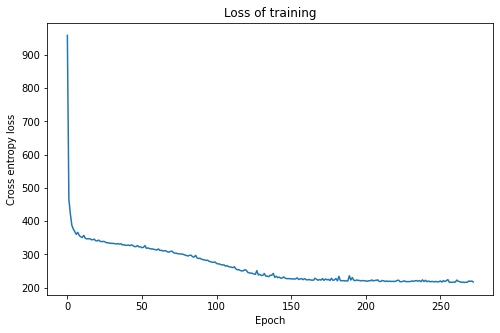

In [161]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model B: 1 Hidden Layers Feedforward Neural Network

### Create model class

In [170]:
batch_size = 50
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

513


In [171]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [172]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.3)
        self.relu1 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim1, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.linear4(out)
        return out

In [173]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 256

In [174]:
model = FNN(input_dim, hidden_dim1, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [175]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]           2,816
           Dropout-2               [-1, 1, 256]               0
              ReLU-3               [-1, 1, 256]               0
            Linear-4                 [-1, 1, 1]             257
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [176]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
LAMBDA = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [177]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/513 | Batch 000/059 | Loss: 7143.6631
Epoch: 001/513 Train Loss: 366.7753
Time elapsed: 0.00 min
Epoch: 002/513 | Batch 000/059 | Loss: 325.7243
Epoch: 002/513 Train Loss: 356.2976
Time elapsed: 0.01 min
Epoch: 003/513 | Batch 000/059 | Loss: 384.9210
Epoch: 003/513 Train Loss: 351.7988
Time elapsed: 0.01 min
Epoch: 004/513 | Batch 000/059 | Loss: 574.1559
Epoch: 004/513 Train Loss: 340.2809
Time elapsed: 0.01 min
Epoch: 005/513 | Batch 000/059 | Loss: 336.5417
Epoch: 005/513 Train Loss: 343.7890
Time elapsed: 0.01 min
Epoch: 006/513 | Batch 000/059 | Loss: 207.1764
Epoch: 006/513 Train Loss: 335.2269
Time elapsed: 0.02 min
Epoch: 007/513 | Batch 000/059 | Loss: 287.7484
Epoch: 007/513 Train Loss: 333.5784
Time elapsed: 0.02 min
Epoch: 008/513 | Batch 000/059 | Loss: 530.5637
Epoch: 008/513 Train Loss: 334.0661
Time elapsed: 0.02 min
Epoch: 009/513 | Batch 000/059 | Loss: 324.0823
Epoch: 009/513 Train Loss: 329.7777
Time elapsed: 0.02 min
Epoch: 010/513 | Batch 000/059 | Los

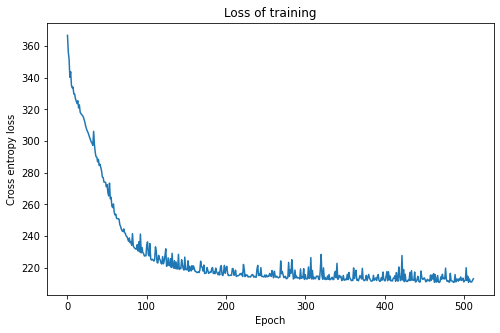

In [178]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## **Optimization:** Different optimizers and batch normalization

## 1. SGD

### Model B: 1 Hidden Layer Feedforward Neural Network

### Create model class

In [179]:
batch_size = 50
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

513


In [180]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [181]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.3)
        self.relu1 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim1, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.linear4(out)
        return out

In [182]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 256

In [183]:
model = FNN(input_dim, hidden_dim1, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [184]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]           2,816
           Dropout-2               [-1, 1, 256]               0
              ReLU-3               [-1, 1, 256]               0
            Linear-4                 [-1, 1, 1]             257
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [185]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
LAMBDA = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [186]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/513 | Batch 000/059 | Loss: 6557.9111
Epoch: 001/513 Train Loss: 366.9059
Time elapsed: 0.00 min
Epoch: 002/513 | Batch 000/059 | Loss: 294.8279
Epoch: 002/513 Train Loss: 349.7394
Time elapsed: 0.01 min
Epoch: 003/513 | Batch 000/059 | Loss: 357.8585
Epoch: 003/513 Train Loss: 345.0372
Time elapsed: 0.01 min
Epoch: 004/513 | Batch 000/059 | Loss: 341.0561
Epoch: 004/513 Train Loss: 341.2540
Time elapsed: 0.01 min
Epoch: 005/513 | Batch 000/059 | Loss: 219.9858
Epoch: 005/513 Train Loss: 338.8375
Time elapsed: 0.01 min
Epoch: 006/513 | Batch 000/059 | Loss: 317.0258
Epoch: 006/513 Train Loss: 334.8321
Time elapsed: 0.02 min
Epoch: 007/513 | Batch 000/059 | Loss: 416.7763
Epoch: 007/513 Train Loss: 333.6553
Time elapsed: 0.02 min
Epoch: 008/513 | Batch 000/059 | Loss: 318.3058
Epoch: 008/513 Train Loss: 330.8125
Time elapsed: 0.02 min
Epoch: 009/513 | Batch 000/059 | Loss: 354.1913
Epoch: 009/513 Train Loss: 329.5482
Time elapsed: 0.02 min
Epoch: 010/513 | Batch 000/059 | Los

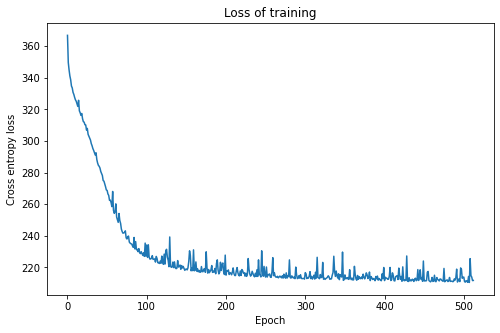

In [187]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 2. SGD Momentum

### Model B: 1 Hidden Layer Feedforward Neural Network

### Create model class

In [197]:
batch_size = 50
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

513


In [198]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [199]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.3)
        self.relu1 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim1, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.linear4(out)
        return out

In [200]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 256

In [201]:
model = FNN(input_dim, hidden_dim1, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [202]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]           2,816
           Dropout-2               [-1, 1, 256]               0
              ReLU-3               [-1, 1, 256]               0
            Linear-4                 [-1, 1, 1]             257
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [203]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
LAMBDA = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA, momentum=0.6)

#### Train the model

In [204]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/513 | Batch 000/059 | Loss: 7039.9849
Epoch: 001/513 Train Loss: 345.1431
Time elapsed: 0.01 min
Epoch: 002/513 | Batch 000/059 | Loss: 254.8773
Epoch: 002/513 Train Loss: 335.0442
Time elapsed: 0.01 min
Epoch: 003/513 | Batch 000/059 | Loss: 358.9052
Epoch: 003/513 Train Loss: 329.6915
Time elapsed: 0.01 min
Epoch: 004/513 | Batch 000/059 | Loss: 326.0017
Epoch: 004/513 Train Loss: 329.7892
Time elapsed: 0.01 min
Epoch: 005/513 | Batch 000/059 | Loss: 261.2112
Epoch: 005/513 Train Loss: 322.7970
Time elapsed: 0.01 min
Epoch: 006/513 | Batch 000/059 | Loss: 430.2898
Epoch: 006/513 Train Loss: 316.1667
Time elapsed: 0.02 min
Epoch: 007/513 | Batch 000/059 | Loss: 441.9327
Epoch: 007/513 Train Loss: 313.8065
Time elapsed: 0.02 min
Epoch: 008/513 | Batch 000/059 | Loss: 343.7231
Epoch: 008/513 Train Loss: 311.2598
Time elapsed: 0.02 min
Epoch: 009/513 | Batch 000/059 | Loss: 628.4368
Epoch: 009/513 Train Loss: 305.3087
Time elapsed: 0.02 min
Epoch: 010/513 | Batch 000/059 | Los

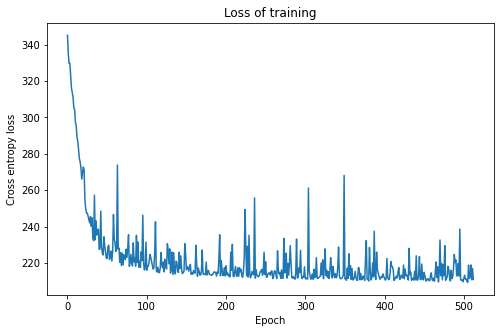

In [205]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 3. SGD Nesterov

### Model B: 1 Hidden Layer Feedforward Neural Network

### Create model class

In [206]:
batch_size = 50
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

513


In [207]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [208]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.3)
        self.relu1 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim1, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.linear4(out)
        return out

In [209]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 256

In [210]:
model = FNN(input_dim, hidden_dim1, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [211]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]           2,816
           Dropout-2               [-1, 1, 256]               0
              ReLU-3               [-1, 1, 256]               0
            Linear-4                 [-1, 1, 1]             257
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [212]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
LAMBDA = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=LAMBDA, momentum=0.6, nesterov=True)

#### Train the model

In [213]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/513 | Batch 000/059 | Loss: 7081.2129
Epoch: 001/513 Train Loss: 350.1418
Time elapsed: 0.01 min
Epoch: 002/513 | Batch 000/059 | Loss: 439.4808
Epoch: 002/513 Train Loss: 340.4605
Time elapsed: 0.01 min
Epoch: 003/513 | Batch 000/059 | Loss: 597.1635
Epoch: 003/513 Train Loss: 335.0772
Time elapsed: 0.01 min
Epoch: 004/513 | Batch 000/059 | Loss: 448.6649
Epoch: 004/513 Train Loss: 339.0919
Time elapsed: 0.01 min
Epoch: 005/513 | Batch 000/059 | Loss: 573.1984
Epoch: 005/513 Train Loss: 329.0674
Time elapsed: 0.01 min
Epoch: 006/513 | Batch 000/059 | Loss: 578.1392
Epoch: 006/513 Train Loss: 333.3672
Time elapsed: 0.02 min
Epoch: 007/513 | Batch 000/059 | Loss: 302.4783
Epoch: 007/513 Train Loss: 320.3042
Time elapsed: 0.02 min
Epoch: 008/513 | Batch 000/059 | Loss: 265.5581
Epoch: 008/513 Train Loss: 316.5804
Time elapsed: 0.02 min
Epoch: 009/513 | Batch 000/059 | Loss: 253.0677
Epoch: 009/513 Train Loss: 321.8779
Time elapsed: 0.02 min
Epoch: 010/513 | Batch 000/059 | Los

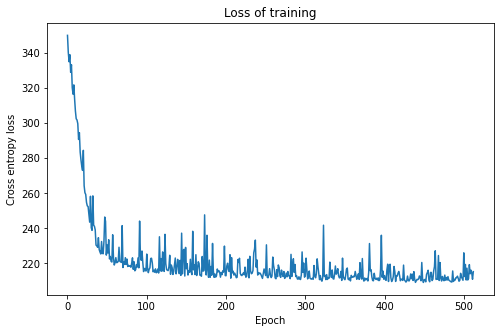

In [214]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 4. Adam

### Model B: 1 Hidden Layer Feedforward Neural Network

### Create model class

In [215]:
batch_size = 50
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

513


In [216]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [217]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.3)
        self.relu1 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim1, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.linear4(out)
        return out

In [218]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 256

In [219]:
model = FNN(input_dim, hidden_dim1, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [220]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]           2,816
           Dropout-2               [-1, 1, 256]               0
              ReLU-3               [-1, 1, 256]               0
            Linear-4                 [-1, 1, 1]             257
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [222]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
LAMBDA = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [223]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/513 | Batch 000/059 | Loss: 6399.1191
Epoch: 001/513 Train Loss: 6847.7333
Time elapsed: 0.01 min
Epoch: 002/513 | Batch 000/059 | Loss: 6948.9365
Epoch: 002/513 Train Loss: 6557.6546
Time elapsed: 0.01 min
Epoch: 003/513 | Batch 000/059 | Loss: 6540.7295
Epoch: 003/513 Train Loss: 6238.4655
Time elapsed: 0.01 min
Epoch: 004/513 | Batch 000/059 | Loss: 7252.2598
Epoch: 004/513 Train Loss: 5877.2511
Time elapsed: 0.01 min
Epoch: 005/513 | Batch 000/059 | Loss: 5177.0259
Epoch: 005/513 Train Loss: 5478.4537
Time elapsed: 0.02 min
Epoch: 006/513 | Batch 000/059 | Loss: 4723.2324
Epoch: 006/513 Train Loss: 5038.7408
Time elapsed: 0.02 min
Epoch: 007/513 | Batch 000/059 | Loss: 5267.1650
Epoch: 007/513 Train Loss: 4565.6131
Time elapsed: 0.02 min
Epoch: 008/513 | Batch 000/059 | Loss: 5271.6851
Epoch: 008/513 Train Loss: 4066.6525
Time elapsed: 0.02 min
Epoch: 009/513 | Batch 000/059 | Loss: 4287.1353
Epoch: 009/513 Train Loss: 3557.6034
Time elapsed: 0.03 min
Epoch: 010/513 | Ba

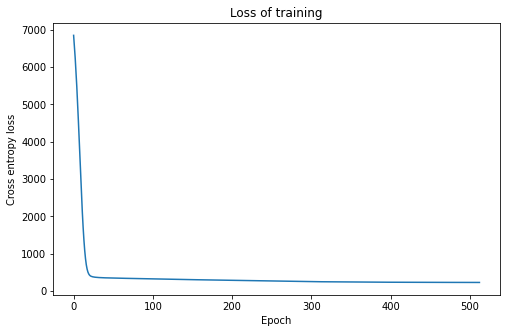

In [224]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 5. Adagrad

### Model B: 1 Hidden Layer Feedforward Neural Network

### Create model class

In [225]:
batch_size = 50
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

513


In [226]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [227]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.3)
        self.relu1 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim1, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.linear4(out)
        return out

In [228]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 256

In [229]:
model = FNN(input_dim, hidden_dim1, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [230]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]           2,816
           Dropout-2               [-1, 1, 256]               0
              ReLU-3               [-1, 1, 256]               0
            Linear-4                 [-1, 1, 1]             257
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [231]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
LAMBDA = 0.05
optimizer = torch.optim.Adagrad(model.parameters(), weight_decay=LAMBDA)

#### Train the model

In [232]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/513 | Batch 000/059 | Loss: 6962.6250
Epoch: 001/513 Train Loss: 427.7682
Time elapsed: 0.01 min
Epoch: 002/513 | Batch 000/059 | Loss: 308.2392
Epoch: 002/513 Train Loss: 364.5264
Time elapsed: 0.01 min
Epoch: 003/513 | Batch 000/059 | Loss: 184.4066
Epoch: 003/513 Train Loss: 355.5832
Time elapsed: 0.01 min
Epoch: 004/513 | Batch 000/059 | Loss: 462.9712
Epoch: 004/513 Train Loss: 351.3162
Time elapsed: 0.01 min
Epoch: 005/513 | Batch 000/059 | Loss: 315.5490
Epoch: 005/513 Train Loss: 348.5631
Time elapsed: 0.01 min
Epoch: 006/513 | Batch 000/059 | Loss: 396.7807
Epoch: 006/513 Train Loss: 346.9019
Time elapsed: 0.02 min
Epoch: 007/513 | Batch 000/059 | Loss: 247.3066
Epoch: 007/513 Train Loss: 344.6237
Time elapsed: 0.02 min
Epoch: 008/513 | Batch 000/059 | Loss: 299.2118
Epoch: 008/513 Train Loss: 343.7583
Time elapsed: 0.02 min
Epoch: 009/513 | Batch 000/059 | Loss: 588.6263
Epoch: 009/513 Train Loss: 341.3760
Time elapsed: 0.02 min
Epoch: 010/513 | Batch 000/059 | Los

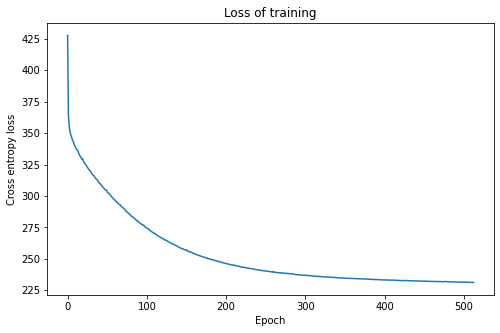

In [233]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 6. Adadelta

### Model B: 1 Hidden Layer Feedforward Neural Network

### Create model class

In [234]:
batch_size = 50
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

513


In [235]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [236]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.3)
        self.relu1 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim1, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.linear4(out)
        return out

In [237]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 256

In [238]:
model = FNN(input_dim, hidden_dim1, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [239]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]           2,816
           Dropout-2               [-1, 1, 256]               0
              ReLU-3               [-1, 1, 256]               0
            Linear-4                 [-1, 1, 1]             257
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [240]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
LAMBDA = 0.05
optimizer = torch.optim.Adadelta(model.parameters(), weight_decay=LAMBDA)

#### Train the model

In [241]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/513 | Batch 000/059 | Loss: 7344.2681
Epoch: 001/513 Train Loss: 344.5282
Time elapsed: 0.01 min
Epoch: 002/513 | Batch 000/059 | Loss: 364.7456
Epoch: 002/513 Train Loss: 335.6779
Time elapsed: 0.01 min
Epoch: 003/513 | Batch 000/059 | Loss: 352.8939
Epoch: 003/513 Train Loss: 328.5791
Time elapsed: 0.01 min
Epoch: 004/513 | Batch 000/059 | Loss: 421.0411
Epoch: 004/513 Train Loss: 320.0314
Time elapsed: 0.01 min
Epoch: 005/513 | Batch 000/059 | Loss: 270.8228
Epoch: 005/513 Train Loss: 316.2087
Time elapsed: 0.02 min
Epoch: 006/513 | Batch 000/059 | Loss: 288.1021
Epoch: 006/513 Train Loss: 306.3942
Time elapsed: 0.02 min
Epoch: 007/513 | Batch 000/059 | Loss: 304.2310
Epoch: 007/513 Train Loss: 292.7584
Time elapsed: 0.02 min
Epoch: 008/513 | Batch 000/059 | Loss: 305.4404
Epoch: 008/513 Train Loss: 285.8483
Time elapsed: 0.02 min
Epoch: 009/513 | Batch 000/059 | Loss: 497.8827
Epoch: 009/513 Train Loss: 291.2030
Time elapsed: 0.03 min
Epoch: 010/513 | Batch 000/059 | Los

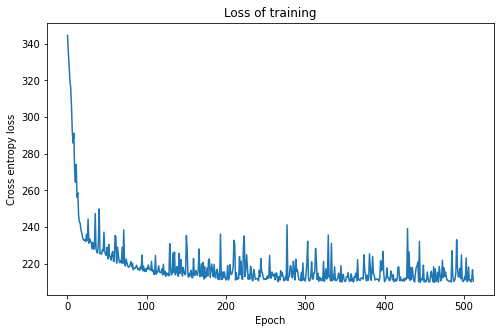

In [242]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 7. Adamax

### Model B: 1 Hidden Layer Feedforward Neural Network

### Create model class

In [243]:
batch_size = 50
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

513


In [244]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [245]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.3)
        self.relu1 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim1, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.linear4(out)
        return out

In [246]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 256

In [247]:
model = FNN(input_dim, hidden_dim1, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [248]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]           2,816
           Dropout-2               [-1, 1, 256]               0
              ReLU-3               [-1, 1, 256]               0
            Linear-4                 [-1, 1, 1]             257
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [249]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
LAMBDA = 0.05
optimizer = torch.optim.Adamax(model.parameters(), weight_decay=LAMBDA)

#### Train the model

In [250]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/513 | Batch 000/059 | Loss: 6790.5347
Epoch: 001/513 Train Loss: 2398.5016
Time elapsed: 0.01 min
Epoch: 002/513 | Batch 000/059 | Loss: 2249.8865
Epoch: 002/513 Train Loss: 403.0018
Time elapsed: 0.01 min
Epoch: 003/513 | Batch 000/059 | Loss: 420.6418
Epoch: 003/513 Train Loss: 367.8562
Time elapsed: 0.01 min
Epoch: 004/513 | Batch 000/059 | Loss: 250.3619
Epoch: 004/513 Train Loss: 354.9342
Time elapsed: 0.01 min
Epoch: 005/513 | Batch 000/059 | Loss: 454.8141
Epoch: 005/513 Train Loss: 351.6441
Time elapsed: 0.02 min
Epoch: 006/513 | Batch 000/059 | Loss: 327.7190
Epoch: 006/513 Train Loss: 346.6802
Time elapsed: 0.02 min
Epoch: 007/513 | Batch 000/059 | Loss: 331.3329
Epoch: 007/513 Train Loss: 344.0728
Time elapsed: 0.02 min
Epoch: 008/513 | Batch 000/059 | Loss: 308.8621
Epoch: 008/513 Train Loss: 341.4399
Time elapsed: 0.02 min
Epoch: 009/513 | Batch 000/059 | Loss: 270.5545
Epoch: 009/513 Train Loss: 339.2635
Time elapsed: 0.03 min
Epoch: 010/513 | Batch 000/059 | L

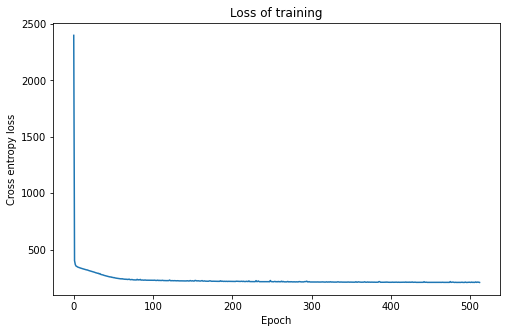

In [251]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 8. RMSProp

### Model B: 1 Hidden Layer Feedforward Neural Network

### Create model class

In [252]:
batch_size = 50
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

513


In [253]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [254]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(0.3)
        self.relu1 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim1, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.linear4(out)
        return out

In [255]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 256

In [256]:
model = FNN(input_dim, hidden_dim1, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [257]:
summary(model, (1,tensor_x.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]           2,816
           Dropout-2               [-1, 1, 256]               0
              ReLU-3               [-1, 1, 256]               0
            Linear-4                 [-1, 1, 1]             257
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [258]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
LAMBDA = 0.05
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [259]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/513 | Batch 000/059 | Loss: 7323.1660
Epoch: 001/513 Train Loss: 6512.9612
Time elapsed: 0.01 min
Epoch: 002/513 | Batch 000/059 | Loss: 6360.2568
Epoch: 002/513 Train Loss: 6147.2818
Time elapsed: 0.01 min
Epoch: 003/513 | Batch 000/059 | Loss: 5195.2656
Epoch: 003/513 Train Loss: 5803.2204
Time elapsed: 0.01 min
Epoch: 004/513 | Batch 000/059 | Loss: 6268.8418
Epoch: 004/513 Train Loss: 5452.6751
Time elapsed: 0.01 min
Epoch: 005/513 | Batch 000/059 | Loss: 5142.9868
Epoch: 005/513 Train Loss: 5087.6417
Time elapsed: 0.01 min
Epoch: 006/513 | Batch 000/059 | Loss: 5538.0869
Epoch: 006/513 Train Loss: 4707.6977
Time elapsed: 0.02 min
Epoch: 007/513 | Batch 000/059 | Loss: 4698.6978
Epoch: 007/513 Train Loss: 4316.3904
Time elapsed: 0.02 min
Epoch: 008/513 | Batch 000/059 | Loss: 3664.9292
Epoch: 008/513 Train Loss: 3917.9313
Time elapsed: 0.02 min
Epoch: 009/513 | Batch 000/059 | Loss: 3865.5667
Epoch: 009/513 Train Loss: 3515.5321
Time elapsed: 0.02 min
Epoch: 010/513 | Ba

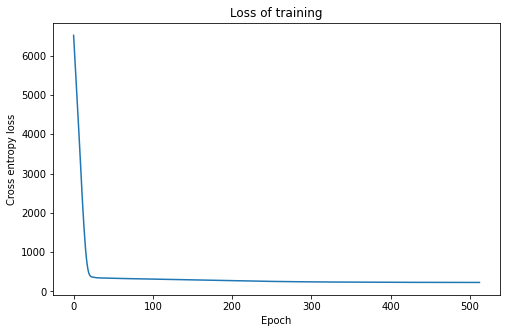

In [260]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## Batch normalization

### Model B: 1 Hidden Layer Feedforward Neural Network

### Create model class

In [299]:
batch_size = 50
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

513


In [300]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [301]:
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(FNN, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim1)
        self.BatchNorm1d1=nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(0.3)
        self.relu1 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_dim1, output_dim)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.BatchNorm1d1(out)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.linear4(out)
        return out

In [302]:
input_dim = tensor_x.shape[1]
output_dim = 1
hidden_dim1 = 256

In [303]:
model = FNN(input_dim, hidden_dim1, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
if torch.cuda.is_available():
    model.cuda()


In [304]:
#summary(model, (1,tensor_x.shape[1]))

In [305]:
criterion = nn.MSELoss(reduction='sum')

learning_rate = 0.0001
LAMBDA = 0.05
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate, weight_decay=LAMBDA)

#### Train the model

In [306]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 1000:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Loss: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Loss: %.2f' % compute_loss(model, train_loader))
    print('Test Loss: %.2f' % compute_loss(model, test_loader))

Epoch: 001/513 | Batch 000/059 | Loss: 6294.1729
Epoch: 001/513 Train Loss: 6434.2974
Time elapsed: 0.00 min
Epoch: 002/513 | Batch 000/059 | Loss: 6542.1777
Epoch: 002/513 Train Loss: 5836.4483
Time elapsed: 0.01 min
Epoch: 003/513 | Batch 000/059 | Loss: 4830.3838
Epoch: 003/513 Train Loss: 5350.1724
Time elapsed: 0.01 min
Epoch: 004/513 | Batch 000/059 | Loss: 5977.6367
Epoch: 004/513 Train Loss: 4903.2834
Time elapsed: 0.01 min
Epoch: 005/513 | Batch 000/059 | Loss: 5142.8252
Epoch: 005/513 Train Loss: 4485.1183
Time elapsed: 0.02 min
Epoch: 006/513 | Batch 000/059 | Loss: 5483.1250
Epoch: 006/513 Train Loss: 4060.1115
Time elapsed: 0.02 min
Epoch: 007/513 | Batch 000/059 | Loss: 5114.7256
Epoch: 007/513 Train Loss: 3647.1382
Time elapsed: 0.02 min
Epoch: 008/513 | Batch 000/059 | Loss: 3441.8293
Epoch: 008/513 Train Loss: 3307.5264
Time elapsed: 0.03 min
Epoch: 009/513 | Batch 000/059 | Loss: 3131.9814
Epoch: 009/513 Train Loss: 2975.7619
Time elapsed: 0.03 min
Epoch: 010/513 | Ba

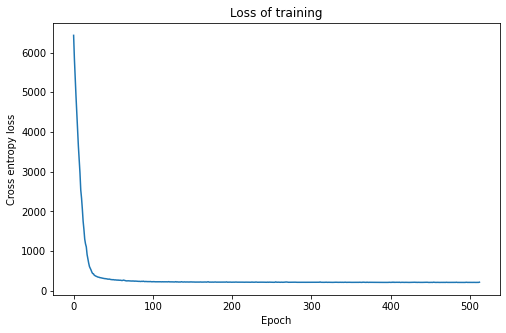

In [308]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## Results of regularizations

| Model Name                    | Training Loss | Test Loss | Training Loss(Dropout) | Test Loss(Dropout) | 
|--------------------------------|----------|----------|----------|----------|
| Model A |  220.02  |  231.08 |  217.57   |   229.48  |
| Model B |  217.62  |  225.09  |  212.96   |   224.75  |

## Results of optimizations (Test loss)
- With dropouts from the regularization part

| Optimizer                    | Model B |
|--------------------------------|----------|
| SGD |  224.20  |
| SGD Momentum |  221.33  | 
| SGD Nesterov |  228.44  | 
| Adam |  238.04  |
| Adagrad |  237.06  |
| Adadelta |  223.24  | 
| **Adamax** |  **220.31**  |
| RMSProp |  236.81  | 


### Batch normalozation
- With dropouts from the regularization part
- We employed best optimizer for the model from the previous table

| Model Name | Optimizer| Training Loss | Test Loss |
|------------|----------|----------|----------|
| Model B |  Adamax  |  216.26  | 230.41  |
